# TDT4173 Project Report

Course: TDT4173 Modern Machine Learning in Practice

Year: 2024

Group name: [55] Ship Happens

Group members:
| Name     | StudentId |
| -------- | ------- |
| Live Krohg  | 564347    |
| Ingvild Langeggen  | 564371     |
| Alexander Sundquist    | 132896    |

## Table of Contents

1. Introduction
2. Exploratory data analysis
3. Feature engineering
4. Modeling
5. Model interpretation

## 1 Introduction

In the following document the steps taken to complete the TDT4173 Modern Machine Learning in Practice project will be described.

### 1.1 Set-up

In [1]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from pyproj import Transformer
from shapely.geometry import MultiPoint

In [3]:
train = pd.read_csv('ais_train.csv', sep='|')
test = pd.read_csv('ais_test.csv', sep=',')
vessels = pd.read_csv('vessels.csv', sep='|')
ports = pd.read_csv('ports.csv', sep='|')
schedules = pd.read_csv('schedules_to_may_2024.csv',sep='|')

- The training dataset, `ais_train.csv`, was imported as the dataframe `train`. 
- The test dataset, `ais_test.csv`, was imported as the dataframe `test`. 
- The vessels dataset, `vessels.csv`, was imported as the dataframe `vessels`. 
- The ports dataset, `ports.csv`, was imported as the dataframe `ports`. 
- The schedules dataset, `schedules_to_may_2024.csv`, was imported as the dataframe `schedules`.

## 2 Exploratory data analysis 

In this part of the report, we are going to explain the steps taken in the Exploratory Data Analysis (EDA) that was conducted prior to feature engieneering and model training. 

### 2.1 Search domain knowledge
In the early phases, time was used to understand each feature in the datasets, and gather information about the domain. Some of the specific domain knowledge is described below.

#### 2.1.1 Vessel speed

Vessels' speed usually varies. Container ships, for example, usually go between 16-24 knots, while some of the fastest cargo ships are able to reach speeds of 37 knots [[1]].


[1]: https://medium.com/@crisri/how-fast-can-large-cargo-ships-go-what-is-the-maximum-speed-that-they-can-safely-travel-at-ae6b1f2c0155

#### 2.1.2 Relationship between cog, sog and heading 

To understand the difference between cog, sog and heading, we used some time to look into what the different features meant. We realised that cog, for example, related to the north vector and that sog and cog were quite different, as opposed to what we initally thought. Heading and cog do not need to be related either, which made it clearer for us to understand what the differece was.

#### 2.1.3 Navigation status

The AIS navigation status is used to describe the operational status of a vessel and is given in integers from 0-15 [[2]]. The status is essential for situational awareness and compliance with maritime regulation. Some codes indicate different technical behaviours but have the same impact on vessel movement, e.g. 1 ("At anchor") and 5 ("Moored"). At anchor means anchoring the vessel using a heavy object, while mooring means tethering the vessel to a fixed object [[3]].

[2]: https://api.vtexplorer.com/docs/ref-navstat.html
[3]: https://vanislemarina.com/news-blog/anchoring-mooring-docking/

#### 2.1.4 Estimated time of arrival

Estimated time of arrival indicates when a vessel is expected to reach a destination.

#### 2.1.5 Shipping lanes

Shipping lanes are the parts of the ocean that vessels use to travel between ports. Shipping lanes can be viewed as highways for vessels. Some of the busiest lanes in the world are The English Channel, The Strait of Malacca, The Panama Canal, The Suez Canal, and The Strait of Hormuz. [[4]] 

Shipping lanes, obviously, has a say in where vessels will and can travel and will probably play a major role in predicting vessels' future locations.

[4]: https://www.hillebrandgori.com/media/publication/shipping-lanes-and-state-of-maritime-traffic

#### 2.1.6 Vessels
AIS identifies vessel types using a coding system called AIS Ship Types that are integers ranging from 0-99 [[5]]. Vessel type usually plays an important role in determining dimensions, displacement, stability, propulsive characteristics and hull form, preliminary general arrangement, and principal structural details [[6]]. Thus, which type of vessel a ship is could probably have a say in what types of routes it usually travels. 

Furthermore, as different vessels often follow different paths related to what kind of ship they are, we looked into the characteristics of the vessels. To give an idicator of what kind of vessel a given vessel was we realized that breadth, length and how much it can carry say much about the characteristics of a ship. When it comes to length and breadth they were given in the vessels information. There were several features related to size and weight the vessels could carry like 'CEU' and 'DWT'. CEU refers to how many car equivalent units a vessel can carry. DWT stands for Deadweight Tonnage and tells us how much a vessel can safely carry. 'GT' provides more information about the volume/sioxe and stands for Gross Tonnage. 

[5]: https://api.vtexplorer.com/docs/ref-aistypes.html
[6]: https://www.marineinsight.com/guidelines/a-guide-to-types-of-ships/

#### 2.1.7 Shipping lines

A shipping line is a company whose line of business is owning and/or operating ships [[7]]. According to the dataset definition, knowing the shipping line can be valuable for "analyzing operational patterns, fleet management, and company-specific performance metrics". We presume that different shipping lines usually specialize in a specific type of shipping, which could create patterns in traveled shipping lanes. For example, if you freight cars or oil probably has a say in which routes your ships usually travel.

[7]: https://en.wikipedia.org/wiki/Shipping_line

### 2.2 Check if the data is intuitive
After learning about the domain, we dived into the datasets to check if the data was intuitive, and if there was any noticable anomalities.

In [25]:
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [26]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


#### 2.2.1 `sog`

When checking if the data is intuitive, the `describe` method was used to gain a overview of the numerical values' distribution. `sog` stood out as a potential non-inuitive case due to its high max value. The high speed challenges our gained domain knowledge that would suggest that the fastest vessels travel up to only 37 knots as stated in [2.1.1 Vessel speed](#2.1.1-vessel-speed). Furthermore, the `sog` mean is 6.3 and the 75%-value is only 14.1. Therefore, a max value of 102.3 seems extreme from a distribution perspective as well. This relationship was further examined using a boxplot, as seen below. The plot shows that the right "whisker is somewhere areound 35 knots and that there are multiple values beyond that value. The extreme values would suggest that they are outliers.

<Axes: xlabel='sog'>

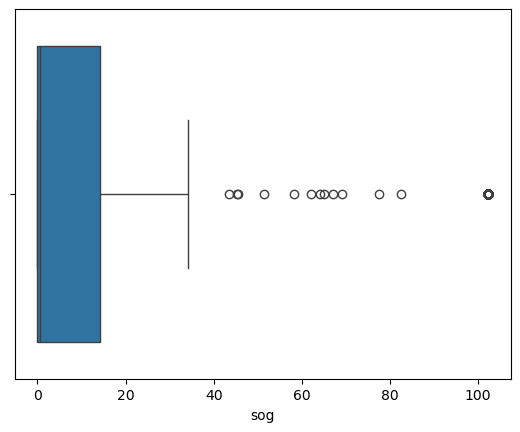

In [4]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = train)

#### 2.2.2 `heading`

In the `describe` table above `heading's` max value of 511 also presents an unintuitive characteristic. `heading` represents the heading of the vessel in degrees and should, thus, not be greater than 360. However, when reading the file "Dataset definitions and explanation" it is described that the value 511 indicates that the heading value is not available and is the default value. Therefore, the max value of 511 is probably not an error, but could cause unintuitive interpretation during model training.

#### 2.2.3 `navstat`

`navstat` shows the current operational state of the vessel and is an integer between 0-15, which is in line with the domain knowledge. According to the data definition, some vessels use more than one code describing their status, e.g. most vessels use code 0 (“Under way using engine”), but from time to time also use 8 (“Under way sailing”). This behaviour is a bit unintuitive and should be handled.

#### 2.2.4 `etaRaw`

`etaRaw` describes the estimated time of arrival at the destination. From the first rows in [2.2 Check if the data is intuitive](#2.2-check-if-the-data-is-intuitive) we can see that the `etaRaw` in a few cases is before the `time` value, which might initially seem unintuitive. It is, however, intuitive, because it indicates that the vessel is late. Nonetheless, this should be handled in the processing, since giving it in its raw form might indicate that it is estimated to arrive in around a years time, instead of being late.

#### 2.2.5 `vesselType`

In [6]:
vessels['vesselType'].value_counts()

vesselType
83.0    580
21.0    117
14.0      2
Name: count, dtype: int64

As seen in the code above, the vessel types that are specified in the `vessels` dataset are 83, 21, and 14. According to the AIS ship types described in [2.1.5 Vessel types](#2.1.5-vessel-types), the code 83 represents "Tanker, Hazardous category C", code 21 represents "Wing in ground (WIG), Hazardous category A", and 14 represents "Reserved for future use". 83 and 21 are intuitive since these represent well defined vessel types. But 14 is unintuitive and could imply that the type of the vessels is not defined. 

Tanker ships are specialized in carrying large amounts of liquid cargo. Tanker ships can be further sub-divided depending on what type of liquid cargo they carry [[7]].

Wing in ground (WIG) is a sub-category to High-Speed Craft and the International Maritime Organization (IMO) describe them as "Wing-in-ground (WIG) craft are supported in their main operational mode solely by aerodynamic forces which enable them to operate at low altitude above the sea surface but out of direct contact with that surface. Accordingly, their arrangement, engineering characteristics, design, construction and operation have a high degree of commonality with those characteristics of aircraft" [8]. Therefore, it can be assumed that they can travel at high speeds and they probably have a different characteristic travel patterns compared to tankers. 

[7]: https://www.marineinsight.com/guidelines/a-guide-to-types-of-ships/
[8]: https://www.imo.org/en/OurWork/Safety/Pages/WIG.aspx

#### 2.2.6 `shippingLineName`

In [14]:
print('Unique shipping lines:', schedules['shippingLineName'].unique())
print('Unique shipping line IDs:', schedules['shippingLineId'].unique())


Unique shipping lines: ['Wallenius Wilhelmsen Ocean' 'Hoegh Autoliners' 'K-Line' 'UECC' 'ACL']
Unique shipping line IDs: ['61a8e672f9cba188601e84ac' '61a8e672f9cba188601e84ab'
 '61a8e673f9cba188601e84ae' '61a8e673f9cba188601e84b3'
 '61be24564ea00ae59d0fe37f']


We can see that there are five different shipping lines which vessels are in the data.

### 2.3 Understand how the data was generated

The data used in the project was supplied by SeaWiz and contains Automatic Identification System (AIS) data and complementary data. The AIS data was collected from 1st January 2024 to 7th May 2024. AIS is an automatic tracking system used on vessels and provides real-time information about a vessel's position, speed, trajectory etc. It is automatically generated.

In [48]:
# Get the unique vessels that are in both training and test data set into a list
unique_vessels_train = train['vesselId'].unique()
unique_vessels_test = test['vesselId'].unique()

common_vessels = list(set(unique_vessels_train) & set(unique_vessels_test))

print('Number of unique vessels in train:', len(unique_vessels_train))
print('Number of unique vessels in test:', len(unique_vessels_test))
print('Number of unique vessels that are the same in training and test:', len(common_vessels))

Number of unique vessels in train: 688
Number of unique vessels in test: 215
Number of unique vessels that are the same in training and test: 215


From the code above, we can see that the AIS traning data set contains 688 unique vessels. However, the entire length of the dataset is much larger, around 1,5 million rows. This implies that each vessel appears multiple times. From inspecting the dataset, it can be seen that the AIS data, like position, speed, and course, is measured every 20 minutes for each vessel.

From the code above, the AIS test dataset contains 215 unique vessels which are all in AIS training as well. If the training and test data is sorted on time, each vessels' last entry in training is 20 minutes before the first entry in the test data. Therefore, we can deduce that the test dataset was generated from the training set. Where the AIS data was sliced at a specific row for each vessel and the earlier part was used for training and the later part was used for testing.

The `schedules`, `ports`, and `vessels` datasets contain supplementary information. `schedules` contains the planned arrival destination and time as specified by specific shipping lines for 252 vessels. `ports` contain information about the ports referenced in `schedules`. `vessels` contain additional information about each vessel. 

### 2.4 Explore individual features

The individual features for each dataset `train`, `test`, `vessels`, `ports`, and `schedules` were examined. First, an overall exploration of all features in each individual dataset was conducted. After that, specific features of interest were examined in more detail.

#### 2.4.1 `train`

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


In [6]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1522065 non-null  object 
 1   cog        1522065 non-null  float64
 2   sog        1522065 non-null  float64
 3   rot        1522065 non-null  int64  
 4   heading    1522065 non-null  int64  
 5   navstat    1522065 non-null  int64  
 6   etaRaw     1522065 non-null  object 
 7   latitude   1522065 non-null  float64
 8   longitude  1522065 non-null  float64
 9   vesselId   1522065 non-null  object 
 10  portId     1520450 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 127.7+ MB


In [7]:
# Check for null values
train.isnull().sum()

time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

As we can see, there are only 1615 null-values in the dataset, and all of these are in the column `portId`. 

In [8]:
# Count duplicate rows
print('Number of duplicate rows in train:', len(train)-len(train.drop_duplicates()))

Number of duplicate rows in train: 0


In [9]:
print('Number of unique vessels in train:', len(train['vesselId'].unique()))

Number of unique vessels in train: 688


In the plots generated below, we are discovering how the different features behave in correlation to each other, for one specific vessel.

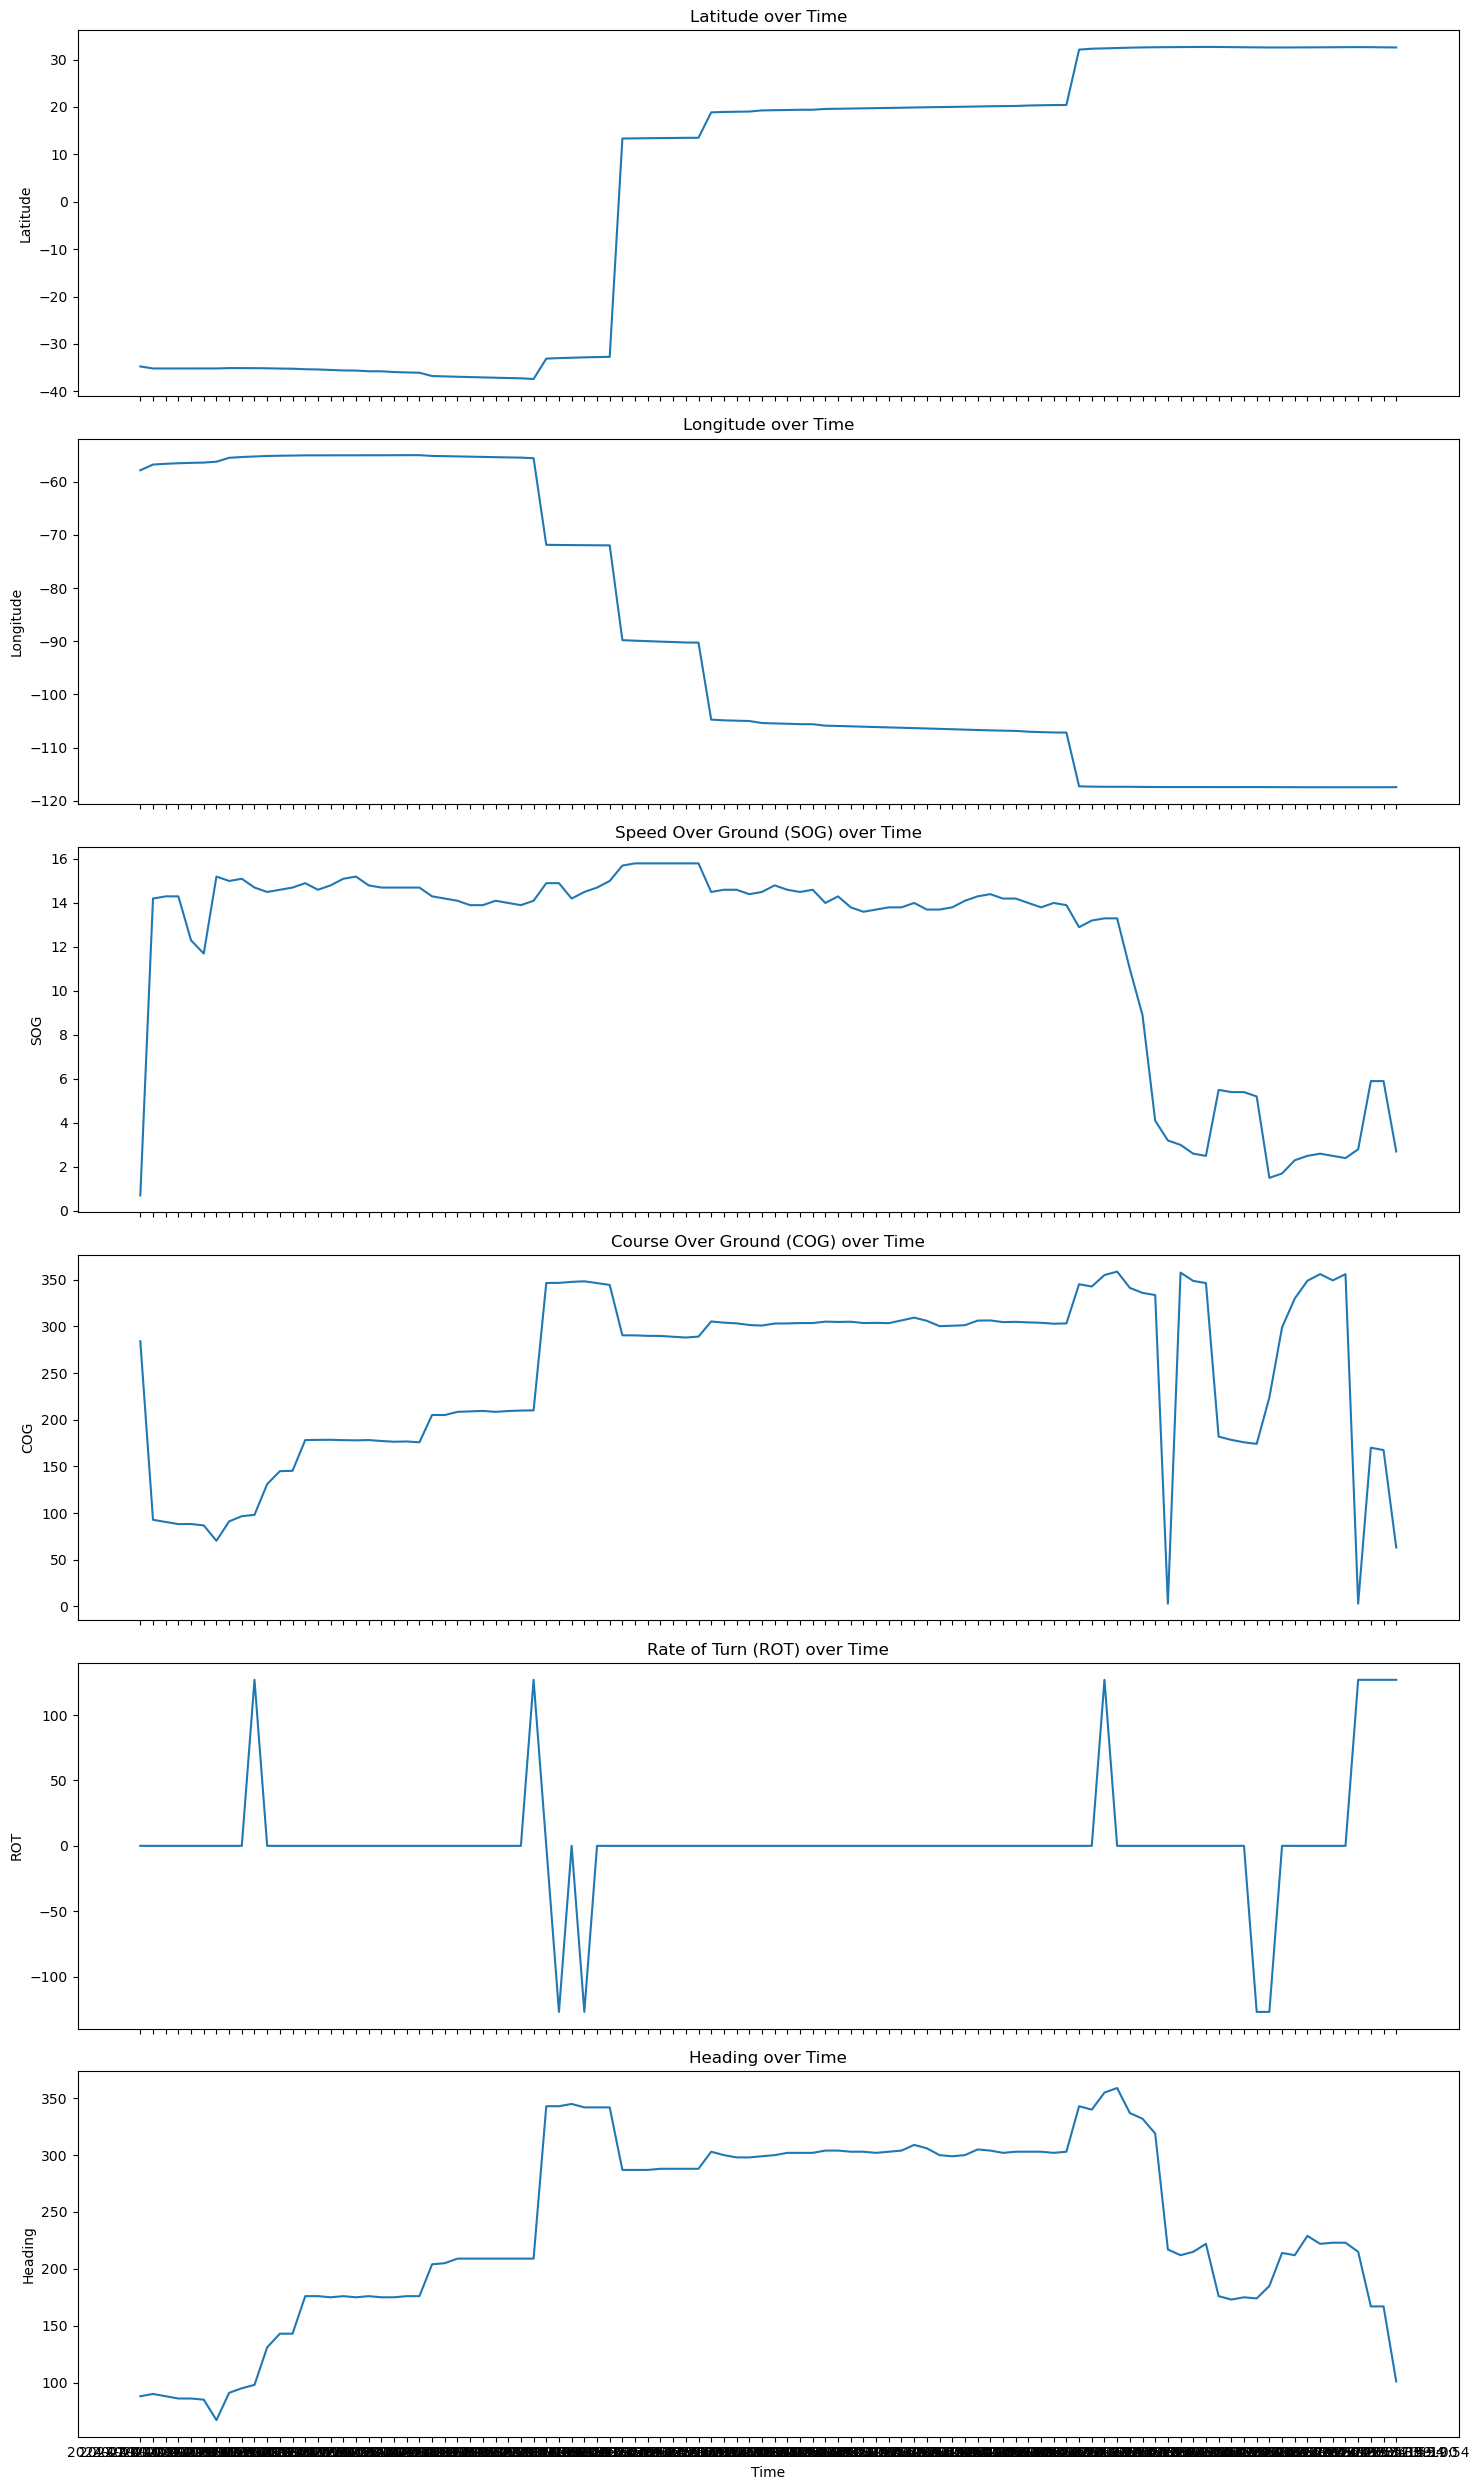

In [10]:
# Filter the dataframe to a smaller time frame, e.g., the first 100 entries for a arbitrarily chosen vessel
ais_train_vessel_small = train[train['vesselId']=='61e9f3a8b937134a3c4bfdf7'].head(100)

# Plot time series for each vessel's latitude, longitude, SOG, COG, ROT, and HEADING
fig, axes = plt.subplots(6, 1, figsize=(15, 25), sharex=True)

# Plot latitude
sns.lineplot(data=ais_train_vessel_small, x='time', y='latitude', ax=axes[0])
axes[0].set_title('Latitude over Time')
axes[0].set_ylabel('Latitude')

# Plot longitude
sns.lineplot(data=ais_train_vessel_small, x='time', y='longitude', ax=axes[1])
axes[1].set_title('Longitude over Time')
axes[1].set_ylabel('Longitude')

# Plot SOG (Speed Over Ground)
sns.lineplot(data=ais_train_vessel_small, x='time', y='sog', ax=axes[2])
axes[2].set_title('Speed Over Ground (SOG) over Time')
axes[2].set_ylabel('SOG')

# Plot COG (Course Over Ground)
sns.lineplot(data=ais_train_vessel_small, x='time', y='cog', ax=axes[3])
axes[3].set_title('Course Over Ground (COG) over Time')
axes[3].set_ylabel('COG')

# Plot ROT (Rate of Turn)
sns.lineplot(data=ais_train_vessel_small, x='time', y='rot', ax=axes[4])
axes[4].set_title('Rate of Turn (ROT) over Time')
axes[4].set_ylabel('ROT')

# Plot Heading
sns.lineplot(data=ais_train_vessel_small, x='time', y='heading', ax=axes[5])
axes[5].set_title('Heading over Time')
axes[5].set_ylabel('Heading')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

##### 2.4.1.1 `navstat`

In [11]:
# Count the occurence of navstat values
train['navstat'].value_counts()

navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
12         1
13         1
14         1
7          1
9          1
Name: count, dtype: int64

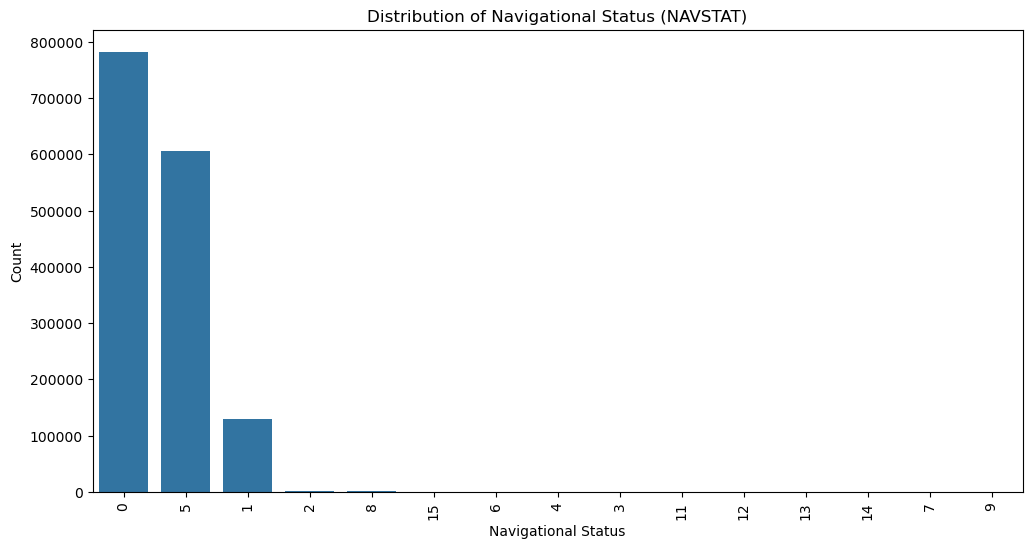

In [12]:
# Analyze the distribution of NAVSTAT (Navigational Status)
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='navstat', order=train['navstat'].value_counts().index)
plt.title('Distribution of Navigational Status (NAVSTAT)')
plt.xlabel('Navigational Status')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In these graphs, we can clearly see that there are mainly three different values for `navstat` that are used in the dataset. 

##### 2.4.1.2 `sog`

<Axes: xlabel='sog'>

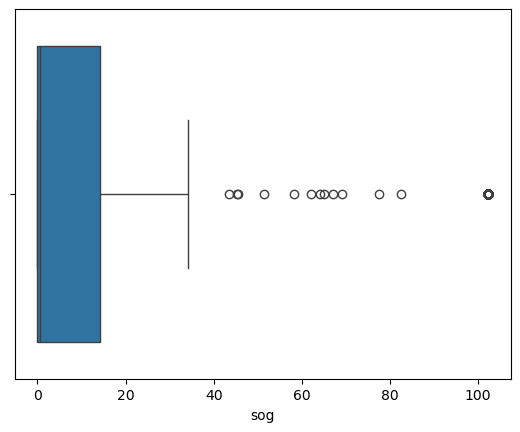

In [13]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = train)

In [14]:
# Count number of rows with sog over 40, which seems to represent the upper outliers
df_sog_greater_40 = train[train['sog'] > 40]    

unique_vessels_sog_greater_40 = df_sog_greater_40['vesselId'].unique()

#print(unique_vessels_sog_greater_40)
print('Number of unique vessels with sog over 40:', len(unique_vessels_sog_greater_40))
print('Number of entries in train with sog over 40:', (train['sog'] > 40).sum())

Number of unique vessels with sog over 40: 33
Number of entries in train with sog over 40: 417


<Axes: xlabel='sog', ylabel='Count'>

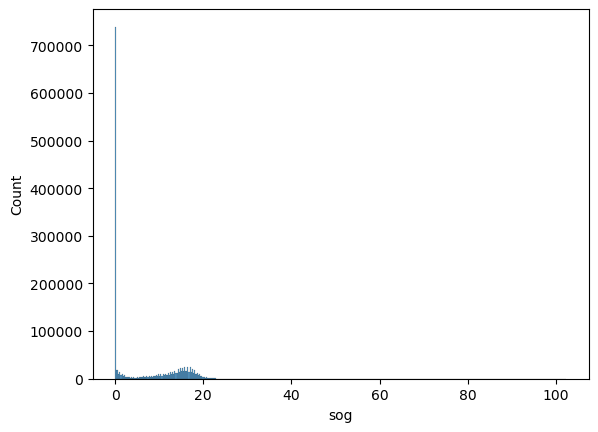

In [15]:
# Plot sog in a histogram
sns.histplot(x='sog',data=train)

In [16]:
# Count the occurence of sog values
train['sog'].value_counts()

sog
0.0     650180
0.1      70767
0.2      18370
0.3      10765
16.0      8906
         ...  
45.2         1
25.3         1
77.5         1
65.0         1
58.2         1
Name: count, Length: 281, dtype: int64

In these graphs, we can see that most `sog`-values are 0, and that they rarely are over 40. 

##### 2.4.1.3 `heading`

<Axes: xlabel='heading', ylabel='Count'>

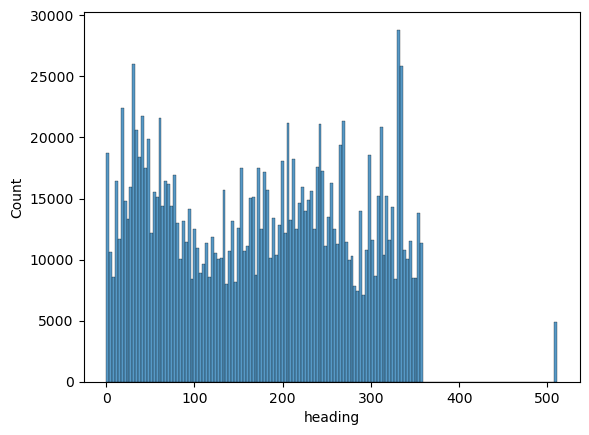

In [17]:
# Plot heading in a histogram
sns.histplot(x='heading', data=train)

<Axes: xlabel='heading'>

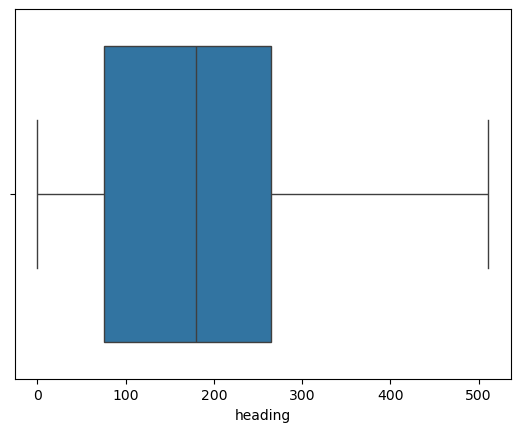

In [18]:
sns.boxplot(x='heading', data=train)

In these plots, we can see that `heading` is mainly between 0 and 360. There are also occurances of the value 511 but they do not appear as outliers in the boxplot.

##### 2.4.1.4 `rot`

<Axes: xlabel='rot'>

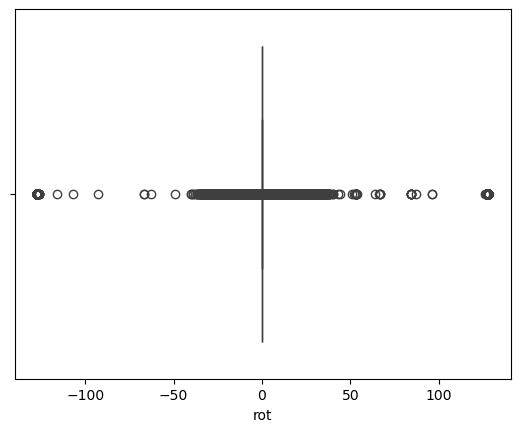

In [19]:
sns.boxplot(x='rot', data=train)

<Axes: xlabel='rot', ylabel='Count'>

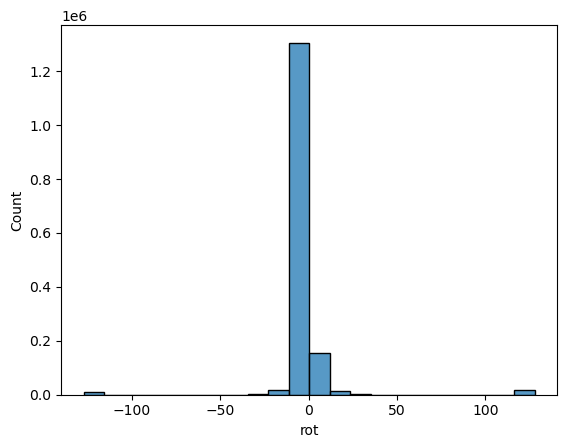

In [20]:
sns.histplot(x='rot', data=train)

In the graphs, we can see that `rot` is mainly beteen -30 and +30 but heavily concentrated around 0.

#### 2.4.2 `test`

As the `test` dataset is not going to be used for training the model, a deep EDA is not as important. It is however good to notice how the predictions are weighted, and on what input data they are being made.

In [21]:
test.head()

,ID,vesselId,time,scaling_factor
0,0,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,0.3
1,1,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,0.3
2,2,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,0.3
3,3,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,0.3
4,4,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,0.3


In [22]:
print('Number of unique vessels in test:', len(test['vesselId'].unique()))

Number of unique vessels in test: 215


#### 2.4.3 `vessels`

In [23]:
vessels.describe().T

,count,mean,std,min,25%,50%,75%,max
CEU,711.0,5006.454290,2186.256335,0.00,3800.00,5400.000,6500.0000,8500.00
DWT,703.0,18556.291607,8562.952922,3222.00,14267.00,18720.000,21281.0000,108650.00
GT,711.0,51207.534459,16329.899399,8659.00,39362.00,56738.000,60619.5000,100430.00
NT,187.0,17931.326203,3838.264571,3137.00,15576.00,18474.000,19152.0000,29329.00
vesselType,699.0,72.424893,23.366361,14.00,83.00,83.000,83.0000,83.00
breadth,703.0,31.102703,3.563432,18.00,31.00,32.000,32.2600,42.00
depth,242.0,21.383140,2.658188,11.90,21.12,21.310,22.0400,32.60
draft,10.0,9.750000,3.229355,5.75,7.64,9.185,9.9325,15.40
enginePower,691.0,6789.522431,7342.526020,0.00,0.00,0.000,14121.0000,36000.00
freshWater,221.0,484.764932,136.657132,178.85,369.00,471.000,567.0000,806.58


In [24]:
vessels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   shippingLineId  711 non-null    object 
 1   vesselId        711 non-null    object 
 2   CEU             711 non-null    int64  
 3   DWT             703 non-null    float64
 4   GT              711 non-null    int64  
 5   NT              187 non-null    float64
 6   vesselType      699 non-null    float64
 7   breadth         703 non-null    float64
 8   depth           242 non-null    float64
 9   draft           10 non-null     float64
 10  enginePower     691 non-null    float64
 11  freshWater      221 non-null    float64
 12  fuel            221 non-null    float64
 13  homePort        573 non-null    object 
 14  length          711 non-null    float64
 15  maxHeight       35 non-null     float64
 16  maxSpeed        213 non-null    float64
 17  maxWidth        35 non-null     flo

In [25]:
# Check for null values
vessels.isnull().sum()

shippingLineId      0
vesselId            0
CEU                 0
DWT                 8
GT                  0
NT                524
vesselType         12
breadth             8
depth             469
draft             701
enginePower        20
freshWater        490
fuel              490
homePort          138
length              0
maxHeight         676
maxSpeed          498
maxWidth          676
rampCapacity      677
yearBuilt           0
dtype: int64

Here, we can see that there are many null values in the dataset.

In [26]:
# Count duplicate rows
print('Number of duplicate rows in vessels:', len(vessels)-len(vessels.drop_duplicates()))

Number of duplicate rows in vessels: 0


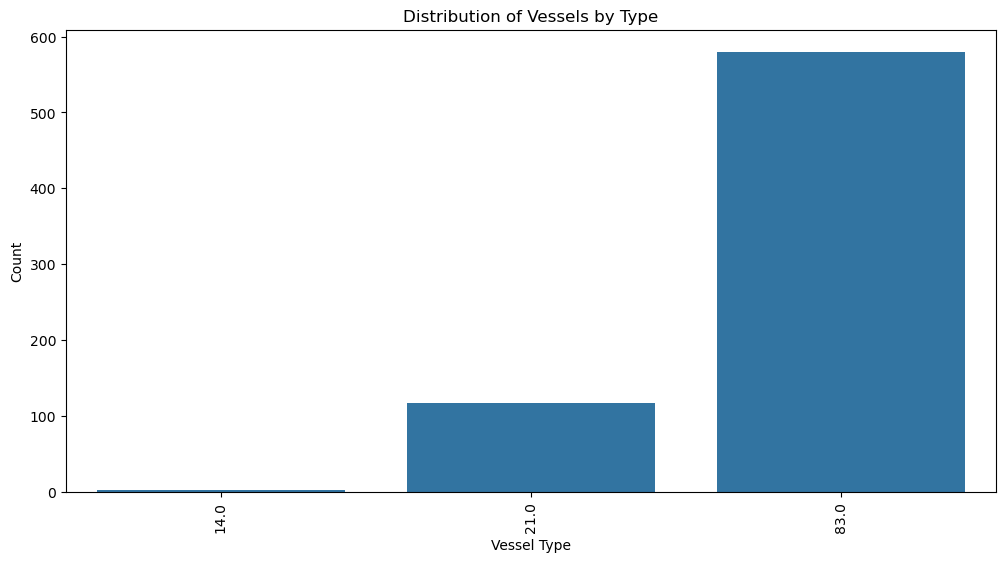

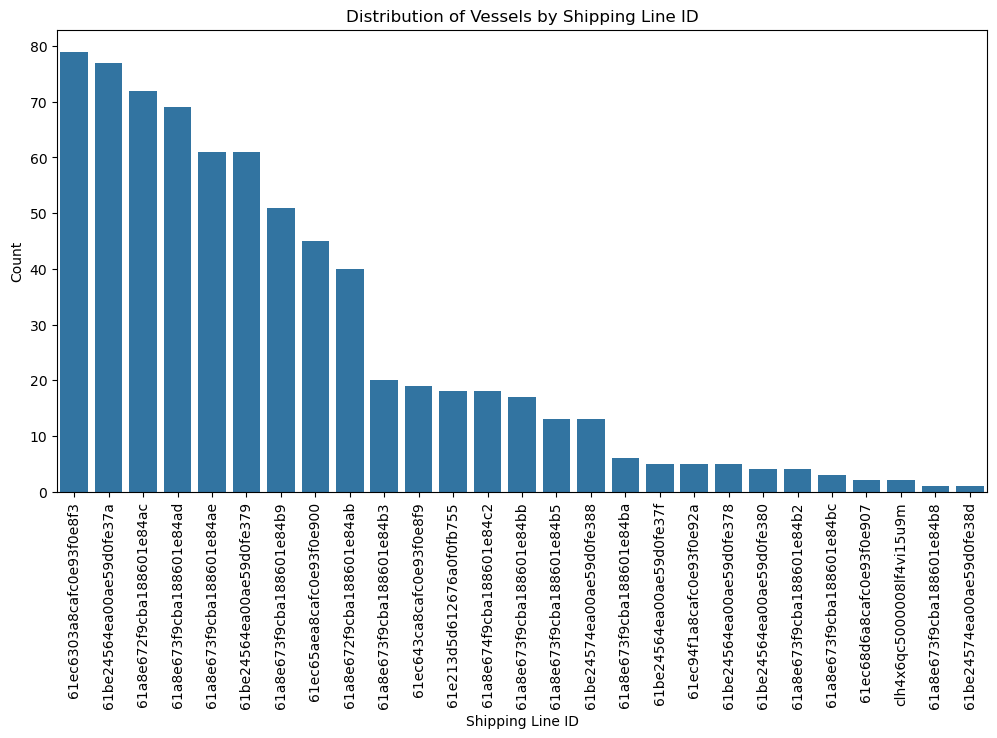

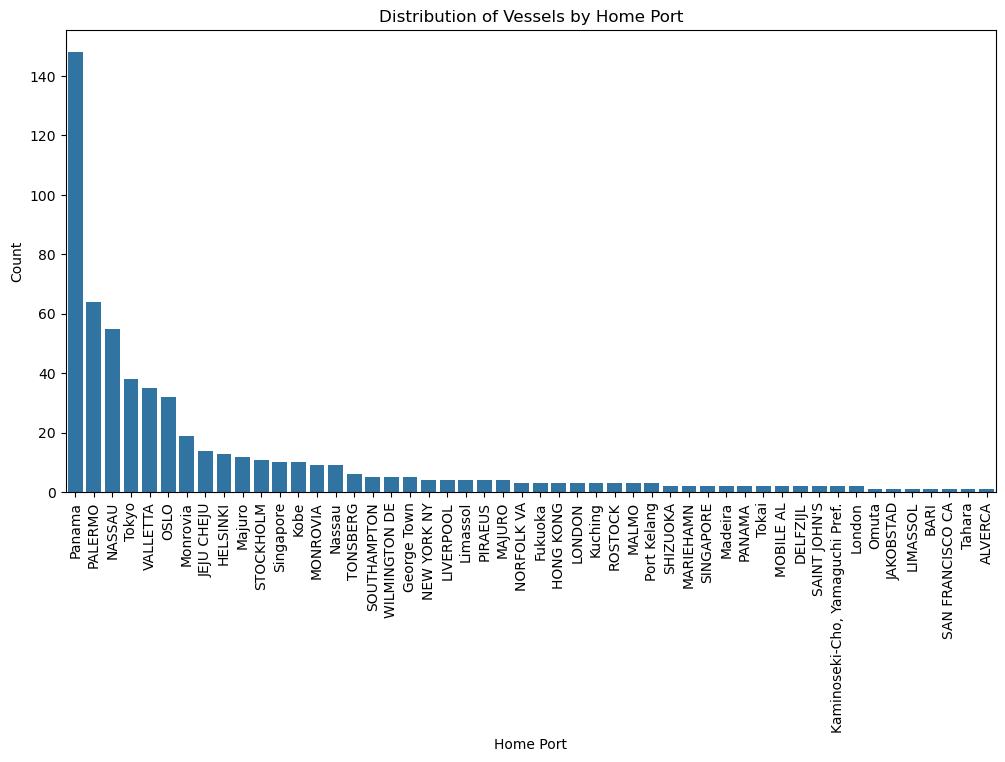

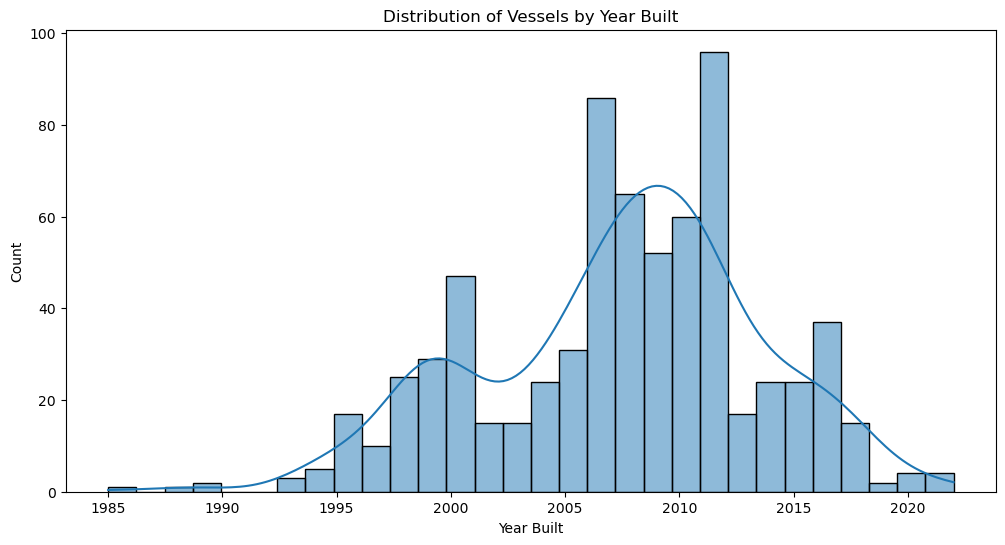

In [27]:
 # Distribution of vessels by vesselType
plt.figure(figsize=(12, 6))
sns.countplot(data=vessels, x='vesselType')
plt.title('Distribution of Vessels by Type')
plt.xlabel('Vessel Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Distribution of vessels by shippingLineId
plt.figure(figsize=(12, 6))
sns.countplot(data=vessels, x='shippingLineId', order=vessels['shippingLineId'].value_counts().index)
plt.title('Distribution of Vessels by Shipping Line ID')
plt.xlabel('Shipping Line ID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Distribution of vessels by homePort
plt.figure(figsize=(12, 6))
sns.countplot(data=vessels, x='homePort', order=vessels['homePort'].value_counts().index)
plt.title('Distribution of Vessels by Home Port')
plt.xlabel('Home Port')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Distribution of vessels by yearBuilt
plt.figure(figsize=(12, 6))
sns.histplot(data=vessels, x='yearBuilt', bins=30, kde=True)
plt.title('Distribution of Vessels by Year Built')
plt.xlabel('Year Built')
plt.ylabel('Count')
plt.show()

#### 2.4.3 `ports`

In [28]:
ports.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,1329.0,20.630528,67.458101,-173.300000,-4.933,13.933,44.583000,178.426111
latitude,1329.0,35.146181,25.098764,-53.794444,25.920,39.050,53.882778,71.643056


In [29]:
ports.head()

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [30]:
ports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portId        1329 non-null   object 
 1   name          1329 non-null   object 
 2   portLocation  1329 non-null   object 
 3   longitude     1329 non-null   float64
 4   latitude      1329 non-null   float64
 5   UN_LOCODE     1329 non-null   object 
 6   countryName   1329 non-null   object 
 7   ISO           1329 non-null   object 
dtypes: float64(2), object(6)
memory usage: 83.2+ KB


In [31]:
# Check for null values
ports.isnull().sum()

portId          0
name            0
portLocation    0
longitude       0
latitude        0
UN_LOCODE       0
countryName     0
ISO             0
dtype: int64

In [32]:
# Count duplicate rows
print('Number of duplicate rows in ports:', len(ports)-len(ports.drop_duplicates()))

Number of duplicate rows in ports: 0


#### 2.4.3 `schedules`

In [33]:
schedules.describe().T

,count,mean,std,min,25%,50%,75%,max
portLatitude,131848.0,28.021038,27.401476,-37.832778,19.208333,35.164167,50.902500,68.795000
portLongitude,131848.0,4.338822,80.059006,-149.571389,-76.558889,3.207222,39.299167,174.771111


In [34]:
schedules.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-02 00:00:00+00:00,2023-10-03 00:00:00+00:00,Port of Brunswick,61d38499b7b7526e1adf3d54,31.140556,-81.496667
1,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-27 00:00:00+00:00,2023-10-27 00:00:00+00:00,Port of Southampton,61d3832bb7b7526e1adf3b63,50.902500,-1.428889
2,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-19 00:00:00+00:00,2023-10-20 00:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
3,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-09 00:00:00+00:00,2023-10-10 00:00:00+00:00,Port of New York,61d38481b7b7526e1adf3d23,40.688333,-74.028611
4,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-09-25 00:00:00+00:00,2023-09-26 00:00:00+00:00,Manzanillo International Terminal,61d37d0199db2ccf7339eee1,9.372370,-79.879790


In [35]:
schedules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136250 entries, 0 to 136249
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   vesselId          131635 non-null  object 
 1   shippingLineId    136250 non-null  object 
 2   shippingLineName  136250 non-null  object 
 3   arrivalDate       130735 non-null  object 
 4   sailingDate       134369 non-null  object 
 5   portName          131848 non-null  object 
 6   portId            131848 non-null  object 
 7   portLatitude      131848 non-null  float64
 8   portLongitude     131848 non-null  float64
dtypes: float64(2), object(7)
memory usage: 9.4+ MB


In [36]:
# Check for null values
schedules.isnull().sum()

vesselId            4615
shippingLineId         0
shippingLineName       0
arrivalDate         5515
sailingDate         1881
portName            4402
portId              4402
portLatitude        4402
portLongitude       4402
dtype: int64

In [37]:
# Count duplicate rows
print('Number of duplicate rows in schedules:', len(schedules)-len(schedules.drop_duplicates()))

Number of duplicate rows in schedules: 87158


### 2.5 Explore pairs and groups of features

#### 2.5.1 `train`

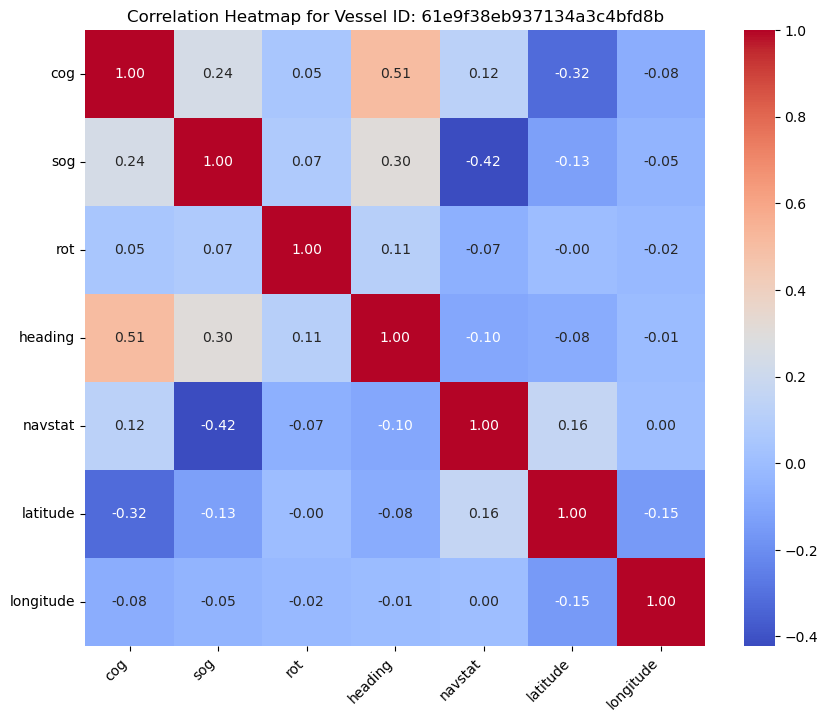

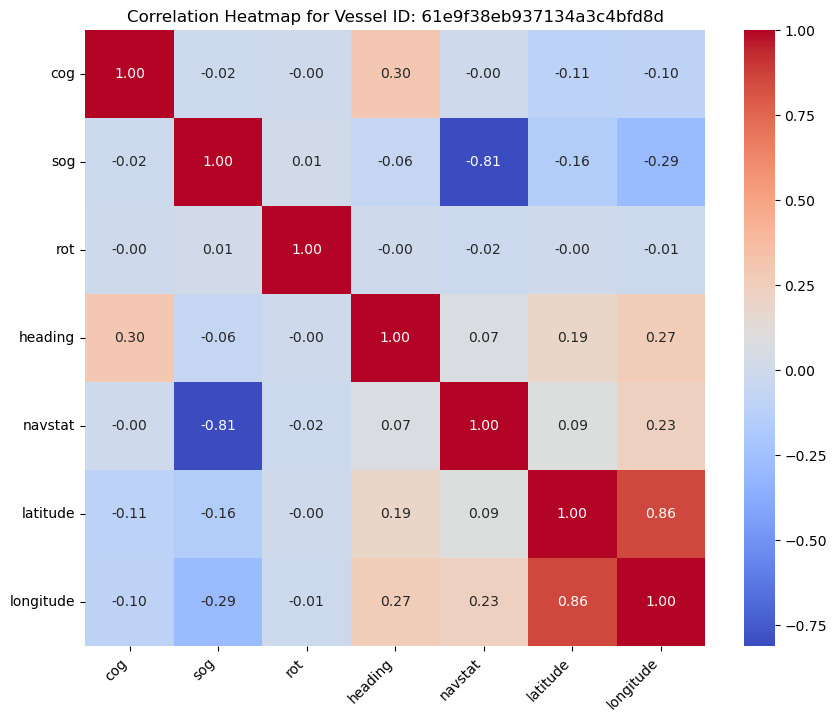

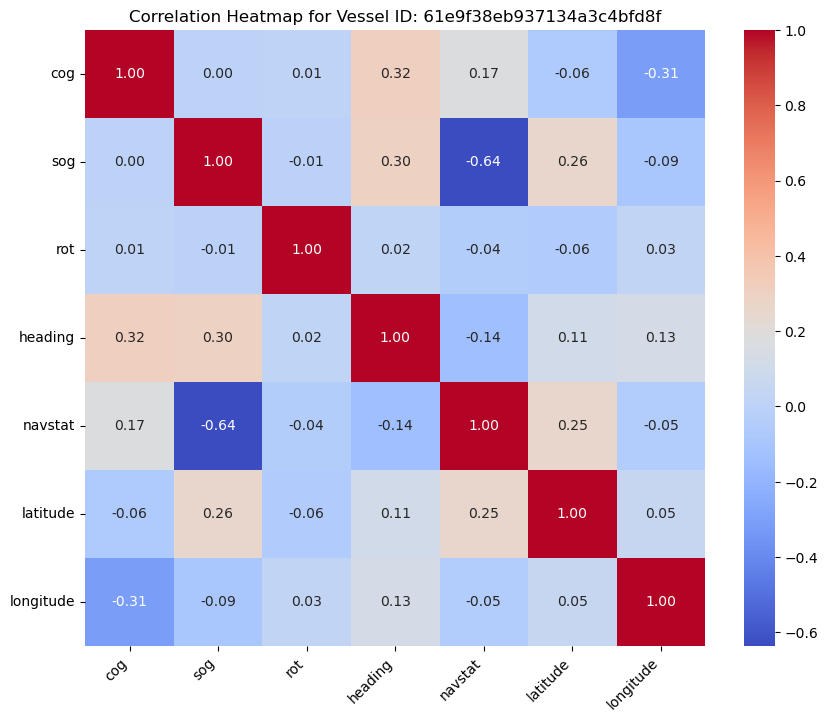

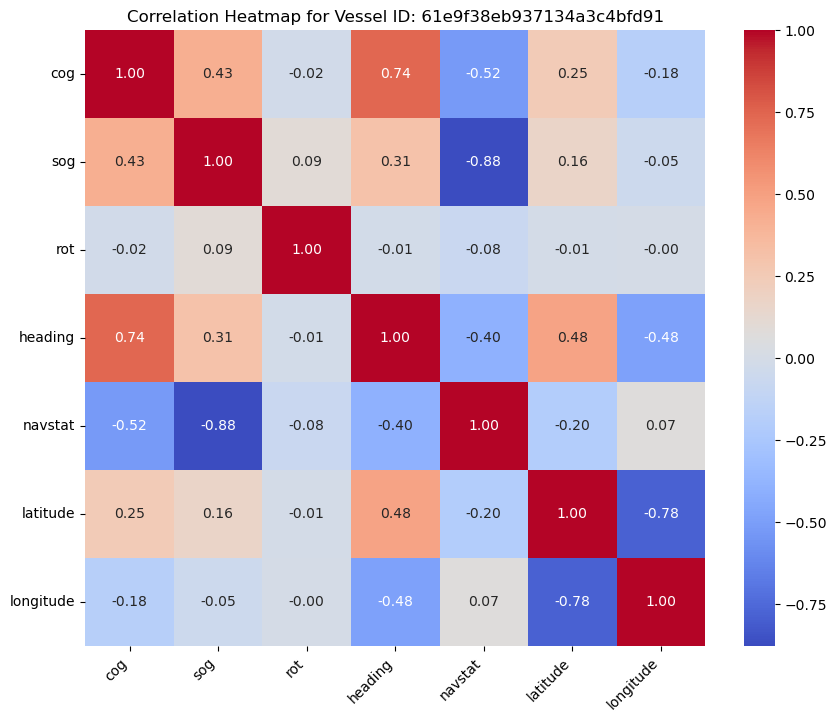

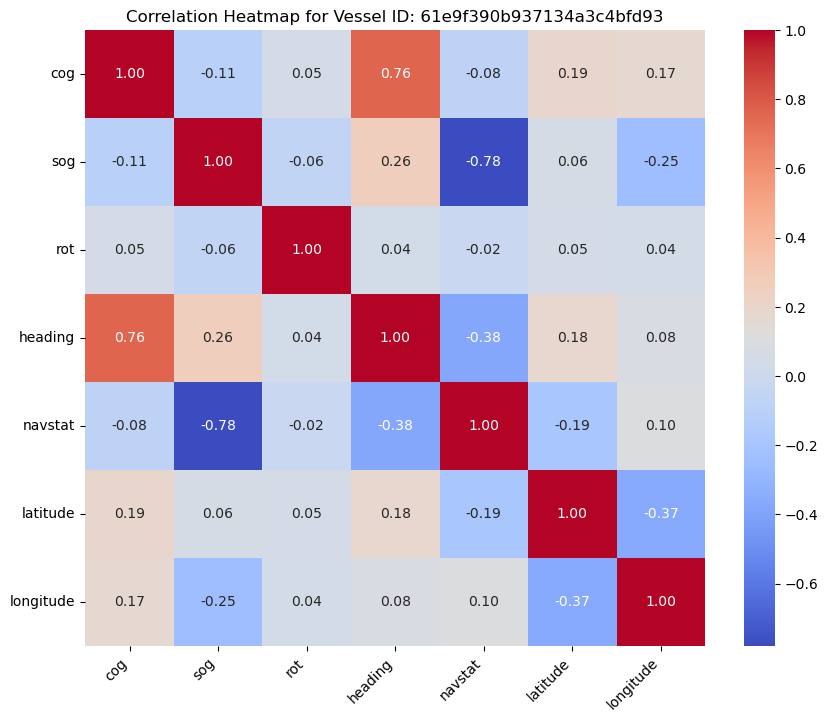

In [43]:
train_filtered = train.drop(columns=['time', 'etaRaw', 'portId'])

grouped = train_filtered.groupby('vesselId')
five_vessels = list(itertools.islice(grouped, 5))

for vessel_id, group in five_vessels:
    numeric_group = group.select_dtypes(include=[float, int])

    correlation_matrix = numeric_group.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for Vessel ID: {vessel_id}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

From the correlation matrix we can get an idea of the correlation between the numerical features in `train`. However, it becomes clear that the correlation between features differs depending on which vessel you examine. 

Some general take aways are that `heading` and `cog` are usually correlated to some extent and `sog` and `navstat` are usually correlated to some extent.

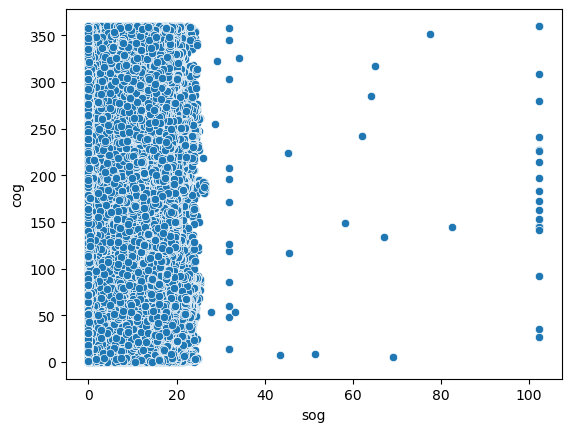

In [39]:
# Scatter plot for 'SOG' vs 'COG'
sns.scatterplot(x=train['sog'], y=train['cog'])
plt.show()

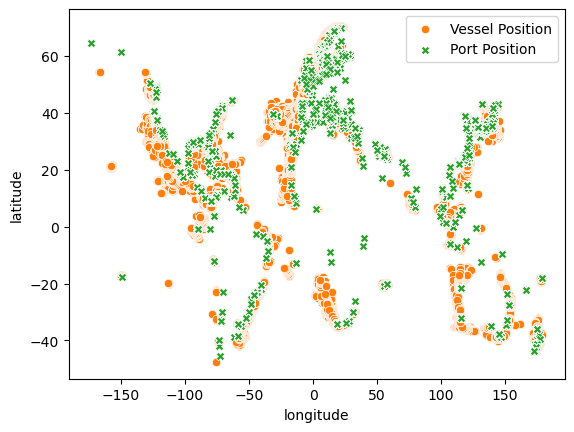

In [40]:
sns.scatterplot(data=train, x='longitude', y='latitude')

# Merge train with ports to get port longitude and latitude
merged_df = train.merge(ports, on='portId', suffixes=('', '_port'))

# Plot the vessel positions and port positions
sns.scatterplot(data=merged_df, x='longitude', y='latitude', label='Vessel Position')
sns.scatterplot(data=merged_df, x='longitude_port', y='latitude_port', label='Port Position', marker='X')

plt.legend()
plt.show()

In [44]:
# Group by 'navstat' and calculate mean values for SOG, ROT, and other movement data
navstat_correlation = train.groupby('navstat').agg({
    'sog': 'mean',
    'rot': 'mean',
    'cog': 'mean',
    'heading': 'mean'
}).reset_index()

print(navstat_correlation)

    navstat        sog         rot         cog     heading
0         0  12.168561    0.201498  173.420699  173.999414
1         1   0.206692    0.249322  182.172731  167.113207
2         2   2.188611    0.253244  190.574531  197.956271
3         3   4.372050    1.496894  173.298758  210.708075
4         4   8.858190   -0.918103  205.141379  172.836207
5         5   0.116614    0.855197  183.615012  180.703239
6         6   7.257390  114.491363  150.158733  489.585413
7         7  17.800000    0.000000  303.300000   80.000000
8         8  11.883966    0.446203  177.432173  172.613924
9         9  12.200000    0.000000  246.500000  245.000000
10       11   5.250000   33.000000  311.650000  291.000000
11       12   0.200000    9.000000  268.000000  358.000000
12       13   0.000000    0.000000   38.300000   77.000000
13       14   2.600000   10.000000  118.300000  115.000000
14       15   0.628806    0.950746  180.789104  283.289552


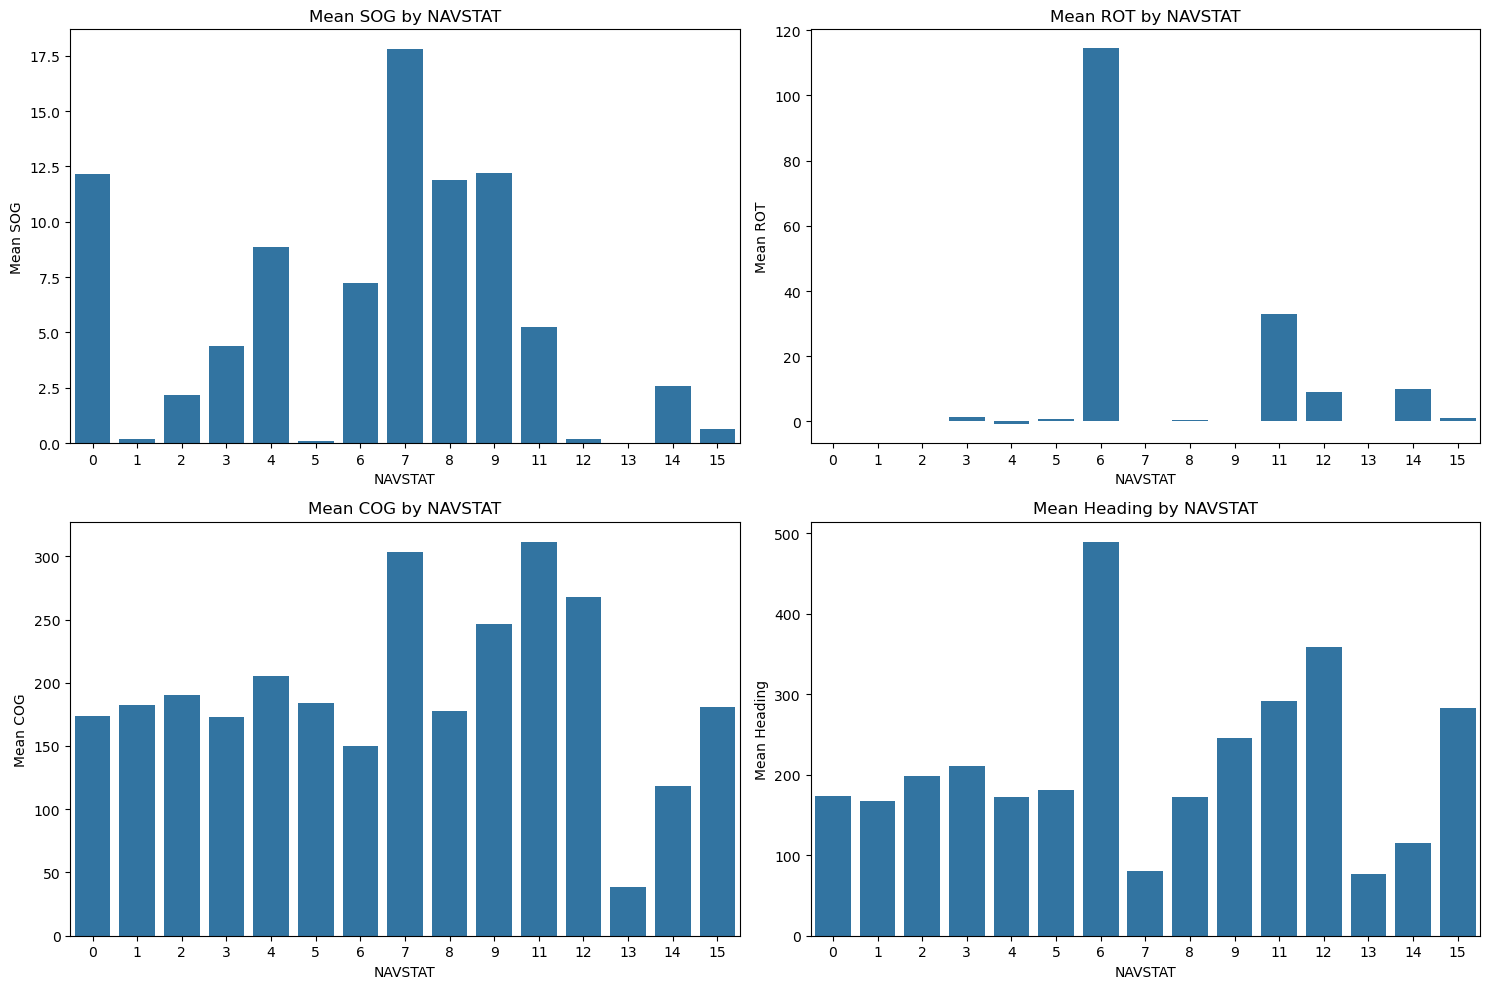

In [45]:
# Plot the correlation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(data=navstat_correlation, x='navstat', y='sog', ax=axes[0, 0])
axes[0, 0].set_title('Mean SOG by NAVSTAT')
axes[0, 0].set_xlabel('NAVSTAT')
axes[0, 0].set_ylabel('Mean SOG')

sns.barplot(data=navstat_correlation, x='navstat', y='rot', ax=axes[0, 1])
axes[0, 1].set_title('Mean ROT by NAVSTAT')
axes[0, 1].set_xlabel('NAVSTAT')
axes[0, 1].set_ylabel('Mean ROT')

sns.barplot(data=navstat_correlation, x='navstat', y='cog', ax=axes[1, 0])
axes[1, 0].set_title('Mean COG by NAVSTAT')
axes[1, 0].set_xlabel('NAVSTAT')
axes[1, 0].set_ylabel('Mean COG')

sns.barplot(data=navstat_correlation, x='navstat', y='heading', ax=axes[1, 1])
axes[1, 1].set_title('Mean Heading by NAVSTAT')
axes[1, 1].set_xlabel('NAVSTAT')
axes[1, 1].set_ylabel('Mean Heading')

plt.tight_layout()
plt.show()

### 2.6 Clean up features

To clean up the features, we formatted the `time`-column to be in Pandas datetime-format, so that it is easier to do calculation with. We also changed the `portId`'s, `vesselId`'s and the `shippingLineId`'s to be integers instead of their hex-encodings. 

In [ ]:
train['time'] = pd.to_datetime(train['time'])
test['time'] = pd.to_datetime(test['time'])

In [ ]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)
schedules['portId'] = schedules['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)
schedules['vesselId'] = schedules['vesselId'].map(vessel_id_mapping)

shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)
schedules['shippingLineId'] = schedules['shippingLineId'].map(shipping_line_id_mapping)

In [ ]:
# Convert sailingDate and arrivalDate to a different timezone, such as CET (Central European Time)
# Convert datetime columns to timezone-naive format by removing timezone info
schedules['sailingDate'] = schedules['sailingDate'].dt.tz_convert(None)
schedules['arrivalDate'] = schedules['arrivalDate'].dt.tz_convert(None)

Impute breadth for missing rows in `vessels`
- the way we chose to impute the values was to fill them with the mean length of the given shipping line that was missing breadth 

In [ ]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'breadth', 'GT']], on='vesselId', how='left')

missing_breadth = train[train['breadth'].isna()]

missing_breadth_counts = (
    missing_breadth.groupby('shippingLineId')['breadth']
    .size()
    .reset_index(name='missing_breadth_count')
)

print("Shipping lines with missing breadth values:")
print(missing_breadth_counts)

num_breadth_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_breadth_nan}")

In [ ]:
mean_breadth_shipping_line_5 = train[train['shippingLineId'] == 5]['breadth'].mean()

train.loc[train['shippingLineId'] == 5, 'breadth'] = train.loc[train['shippingLineId'] == 5, 'breadth'].fillna(mean_breadth_shipping_line_5)

missing_count_after_imputation = train['breadth'].isnull().sum()
print(f"Missing Breadth values after imputation: {missing_count_after_imputation}")

## 3 Feature engineering

For the feature engineering, both feature selection and extraction were conducted. The feature engineering was initially based on the exploratory data analysis but was also adjusted iteratively based on prediction results.

The main function for feature engineering `feature_engineering(test,train)` can be seen below. The function inputs the test dataframe and the train dataframe and returns the dataframe, `features` with the decired features. In the following parts the specific feature selection and extraction that was conducted will be described in more detail.

In [3]:
def feature_engineering(train):
    train = train.copy()

    # Sort data to ensure time sequence within each vessel
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # Handle NaNs by filling forward then backward within each vessel's data
    train[['latitude', 'longitude', 'cog', 'time']] = (
        train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    
    # Create five-day sliding windows for each vessel
    features = create_five_day_windows(features)
    

    # Additional time and angle transformations
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute

    return features

### 3.1 Feature selection

When conducting the feature selection, the dataframe `features` was created in the function `feature_engineering(test,train)` where the desired features from the dataframes `train` and `ports` were appended.

#### 3.1.1 Selection from `train`

From `train`, the features `vesselId`, `portId`, `latitude`, `longitude`, `cog`, and `sog` were directly selected. 

The calendar features, `month`, `day`, `hour`, and `minute`, describing the time at which the data point was recorded were also included as seperate featuers. The year and second that were also included in the raw data were, however, left out. The year for all data was 2024 which means that there was no variability and no information to be gained from including the feature. Seconds were to granular to provide any information.

The features `heading` and `rot` from `train` were not selected as final features. `heading` was not selected due to its high correlation with `cog`, which was deemed to be a more accurate representation of vessel direction **(is this true?)**. `rot` was not included as a feature due to its inclusion reducing performance **(is this true?)**

The features `etaRaw` and `navstat` from `train` were not directly selected but instead used to generate new features, which is described in more detail in [3.2 Feature engineering](#3.2-feature-engineering). `etaRaw` was not selected directly because it proved to be more valuable as a relational feature to `time`. `navstat` was not selected due to it mainly describing two states, under way, given by the feature values 0 and 8 and not under way, given by the feature values 1 and 5.

#### 3.1.2 Selection from `ports`

From `ports`, the features `longitude` and `latitude` were selected, and called `portLongitude` and `portLatitude`. The motivation was to give the model an idea of the vessels final location.

### 3.1.3 Selection from `vessels`


To incorporate the data of a vessel into the training we chose to incorporate breadth, lenght and GT to represent the size and volume of a vessel. Due to missing data and uncertainty about how to calculate and impute DWT and CEU, which give more insight into the weight-carrying aspect of a vessel, we chose to not add them in our features. 

### 3.2 Feature extraction

#### 3.2.1 `under_way`

As mentioned in [3.1.1](#3.1.1-selected-from-train) `navstat` was not selected, but instead used to generate a new feature called `under_way`. The new feature values were set to 1 if the `navstat` value was 0 or 8 and set to 0 in all other cases.

```python
features['under_way'] = train['navstat'].isin([0, 8]).astype(int)

#### 3.2.2 Five-day window

As we are going to predict vessels future position up to five days ahead, we decided to create five-day windows for each of the vessels. In these windows, each row is pointing to the first row of the window and adding time `time_since_start`-feature. This feature describes how many seconds it has been since the start of the five-day window. The function can be seen in the `create_five_day_windows(df)` below. 

In [2]:
def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    
    window_size_days = 5
    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        for start_idx in range(len(unique_dates) - window_size_days + 1):
            start_date = unique_dates[start_idx]
            end_date = unique_dates[start_idx + window_size_days - 1]
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # Skip empty windows
            if len(window) == 0:
                continue

            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'cog': row['cog'],
                    'sog': row['sog'],
                    'rot': row['rot'],
                    'under_way': row['under_way'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_first': reference_row['cog'],
                    'sog_first': reference_row['sog'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

    return pd.DataFrame(windows)

#### 3.2.4 Time to arrival

The time to arrival, represented in the feature `time_difference_eta`, was extracted by subtracting the eta with the current time, as seen in the main function `feature_engineering_heading`. Firstly, however, the feature `etaRaw` in `train` had to be preprocessed to allow for the feature extraction, which was done by the function `convert_eta_raw(row)` seen below. `etaRaw` had to be converted to the datetime format and also had to be handled if the `etaRaw` value was earlier than `time` value of when the data was recorded.

In [1]:
# Function to convert 'etaRaw' to datetime format, handling year rollovers
def convert_eta_raw(row):
    current_year = row['time'].year  # Get the year from the 'time' column
    eta_with_year = f"{current_year}-{row['etaRaw']}"  # Create full datetime string
    eta_datetime = pd.to_datetime(eta_with_year, format='%Y-%m-%d %H:%M', errors='coerce')
    
    # Adjust year if 'etaRaw' is earlier than 'time'
    if eta_datetime < row['time']:
        eta_datetime = eta_datetime + timedelta(days=365)
    return eta_datetime

#### 3.2.5 Distance to port

The feature `distance_to_port` in our first prediction is calculated by merging the training dataset with `ports`. Then, the function `haversine` is used to calculate the distance.

```python
train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()


def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers
```

#### 3.2.6 Covered area
To calculate the area covered by each vessel, we used the function `compute_area_covered` in the second submission.

In [ ]:
def compute_area_covered(dataframe, group_by_column='vesselId'):
    dataframe['area_covered'] = 0.0
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)  # WGS84 to Web Mercator

    for vessel_id, group in dataframe.groupby(group_by_column):
        coordinates = group[['longitude', 'latitude']].dropna().values
        if len(coordinates) >= 3:
            x_coords, y_coords = transformer.transform(coordinates[:, 0], coordinates[:, 1])
            projected_coordinates = list(zip(x_coords, y_coords))
            
            convex_hull = MultiPoint(projected_coordinates).convex_hull
            area_in_square_meters = convex_hull.area  
            area_in_square_kilometers = area_in_square_meters / 1e6  
        else:
            area_in_square_kilometers = 0
        
        # Assign the area back to each row in the group
        dataframe.loc[group.index, 'area_covered'] = area_in_square_kilometers

    return dataframe

## 4 Modeling

**To avoid the deduction, you should show that you have tried two or more types of predictors in the report (e.g., XGBoost and Random Forest). It is allowed to use only one type of predictor in a short notebook for Kaggle predictions.**

During the data preprocessing and feature engineering process, the XGBoost model was used to validate iterations due to its quick run time. When a desirable preprocessing and feature engineering had been completed, a model testing phase was initiated. During testing three types of predictors were tested: XGBoost, Random Forest, and Long Short Term Memory. The best performing model was selected as the final model. Lastly, hyper-parameter tuning was conducted for the selected model.

### 4.1 Model testing

#### 4.1.1 XGBoost

XGBoost was used for one iteration and gave the Kaggle result 116.53366.

#### 4.1.2 Random Forest

Random Forest was used for one iteration and gave the Kaggle result 100.67332

#### 4.1.3 Long Short Term Memory (LSTM)
Due to the time-series nature of out project, we wanted to test LSTM and se how it performes compared with Random Forest. In our case, the LSTM model performed worse than the random forest model. Thus, we continued on with random forest for our projet.

### 4.2 Final model - Random Forest

#### 4.2.1 Hyper-parameter tuning

For hyperparameter tuning of our RandomForestRegressor model, we used a randomized search with cross-validation to explore a range of values for key parameters. We focused on optimizing `max_depth` (controlling tree depth) to prevent overfitting, along with other parameters like `n_estimators` (number of trees) and `max_features` (number of features to consider at each split). After evaluating various combinations, we found that setting `max_depth` to 25 provided the best balance between model accuracy and generalization. The final model, with `random_state=42` for reproducibility and `n_jobs=-1` for faster computation, was then trained on the full dataset.

## 5 Model interpretation

**To avoid the deduction, you should show one or more model interpretation results (e.g., PDP, feature importance, LIME) in the report.**

### 5.1 Feature Importance

We have chosen to interpret the models that are given in the two short notebooks, Random Forest and XGBoost. Feature importance analysis helps us understand which variables contribute most to the model's predictions. 

### Feature Importances
#### Random forest

| Feature             | Importance |
|---------------------|-----------|
| longitude_first     | 0.739001  |
| time_since_start    | 0.115180  |
| latitude_first      | 0.079880  |
| GT                  | 0.013979  |
| cog_sin_first       | 0.010984  |
| length              | 0.006378  |
| sog_first           | 0.005909  |
| breadth             | 0.005353  |
| cog_cos_first       | 0.004565  |
| day                 | 0.004045  |
| sog                 | 0.003519  |
| cog_sin             | 0.003342  |
| month               | 0.002147  |
| distance_to_port    | 0.001563  |
| cog                 | 0.001162  |
| cog_cos             | 0.000796  |
| longitude_port      | 0.000600  |
| latitude_port       | 0.000566  |
| under_way           | 0.000512  |
| under_way_first     | 0.000224  |
| hour                | 0.000164  |
| rot                 | 0.000098  |
| minute              | 0.000034  |

#### XGBoost
| Feature          |   Importance |
|:-----------------|-------------:|
| longitude_first  |  0.67369     |
| latitude_first   |  0.1245      |
| time_since_start |  0.0776558   |
| area_covered     |  0.0295075   |
| cog_first        |  0.0143975   |
| under_way_first  |  0.0134453   |
| sog              |  0.0129422   |
| cog              |  0.0102032   |
| month            |  0.0101289   |
| vesselId         |  0.00987215  |
| sog_first        |  0.00966008  |
| under_way        |  0.00743065  |
| day              |  0.00596653  |
| minute           |  0.000406395 |
| hour             |  0.000193675 |


Key Insights:

- Longitude_first was found to be the most important feature, with the highest importance for both models. This indicates that the model places significant weight on the longitude referring to the row at the start of the five-day window when making predictions.
- Other features such as time_since_start and latitude_first also had considerable importance, further emphasizing the model's reliance on the first data within the five-day window.
- Features like minute and rot were found to have minimal impact on the predictions, with near-zero importance scores, suggesting that these features are less predictive in the context of the model.

The term _first in the feature names refers to the first value observed on the first day within a five-day window. This suggests that the model places considerable importance on the data collected at the start of this period, indicating that initial conditions (such as the longitude and latitude at the beginning of the window) are important for accurate predictions.